In [9]:
import inspect
import matplotlib.pyplot as plt
import nbformat
import numpy as np
import os
import pandas as pd
import pickle
import re
import scipy.stats as stats
import seaborn as sns
import shap
import subprocess
import sys
from google.colab import drive, output
from lightgbm import LGBMClassifier
from nbformat import read, write
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, precision_recall_curve, precision_score, recall_score, roc_auc_score, roc_curve, auc
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [282]:
df = pd.read_csv("reiseversicherung.csv")
#df = pd.read_csv("C:\\VKB\\reiseversicherung.csv")

# Datenexploration

In [267]:
df

,Agenturname,Agenturtyp,Vertriebskanal,Produktname,Leistungseintritt,Reisedauer,Reiseziel,Nettoumsatz,Kommission,Geschlecht,Alter
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,NaN,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,NaN,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,NaN,41
...,...,...,...,...,...,...,...,...,...,...,...
63321,JZI,Airlines,Online,Basic Plan,No,111,JAPAN,35.0,12.25,M,31
63322,JZI,Airlines,Online,Basic Plan,No,58,CHINA,40.0,14.00,F,40
63323,JZI,Airlines,Online,Basic Plan,No,2,MALAYSIA,18.0,6.30,M,57
63324,JZI,Airlines,Online,Basic Plan,No,3,VIET NAM,18.0,6.30,M,63


In [283]:
df.describe()

,Reisedauer,Nettoumsatz,Kommission,Alter
count,63326.000000,63326.000000,63326.000000,63326.000000
mean,49.317074,40.702018,9.809992,39.969981
std,101.791566,48.845637,19.804388,14.017010
min,-2.000000,-389.000000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.530000,0.000000,36.000000
75%,53.000000,48.000000,11.550000,43.000000
max,4881.000000,810.000000,283.500000,118.000000


In [269]:
#pip install sweetviz
#import sweetviz as sv

In [270]:
# Automatische Datenanalyse
#report = sv.analyze(df, target_feat='Leistungseintritt')

# Report anzeigen
#report.show_html("sweetviz_report.html")

## SweetViz Ergebnisse



Allgemeine Informationen:

*   63326 Datenpunkte und 11 Spalten (10 Features; 1 Zielvariable)


Datenqualität


*   Unbalanced Dataset: Leistungseintritt unter 1,5% (Insgesamt nur 927)
-> Mögliche Auswirkung: Modell bevorzugt Mehrheitsklasse (Kein Leistungseintritt)
-> Mögliche Lösungsmöglichkeiten: Undersampling, Oversampling, class_weigt=balanced, Threshold anpassen
-> Verwendete Lösung: Keine Gewichtung oder Data Sampling(Verzerrt Interpretierbarkeit der Wahrscheinlichkeiten)
--> Analyse der ROC-AUC Kurve und Precision-Recall-Curve

___

*   Fehlende Werte : Bei "Geschlecht" sehr hoch (71%) -> Wenig nützliche Information

-> Mögliche Lösungen:

- Feature löschen mit fehlenden Werten (Mögl. hoher Informationsverlust)
- Schätzen
- Modell welches das Geschlecht vorhersagt (Da die anderen Features Informationen über Geschlecht geben)
-> Verwendete Lösung: Entfernen des Features Geschlecht (geringe Korrelation mit Zielvariable)
-> Korrelation mit Agenturname und Produktname (tw. fehlen alle Geschlechtsdaten in einer Agentur, zB EPX -> Hier wurden die Daten evtl. gar nicht erfasst)

___

* Generell z u prüfende Werte:
- Alter: Tw. sehr hoch -> Einige ca. 115 Jahre
- Alter: Hoher Anteil im Bereich ~ 38-40 Jahre
- Ausreißer: Reisedauer -> Muss kein Fehler sein

- Agenturname: Über 50% EPX; Ersten 4 Agenturen fast 100% (evtl. seltene Zusammenfassen)
- Reiseziel: viele Seltene (evtl. zusammenfassen, je nach Modell, um Multikollinearität zu vermeiden)

___

* Korrelationen
- Höchste Korrelation mit Zielvariable: Produktname
- Sehr hohe Korrelationen zwischen Features
--> Überlegung der Feature Reduction um ggf. bessere Mustererkennung möglich zu machen (Overfitting, Dimensionalität, Rechenaufwand, Generalisierung)








___
## Tiefere Analysen (der im SweetViz Report beobachteten Auffälligkeiten)

Da Geschlecht viele fehlende Werte beinhaltet (Nan) wird dies nun näher betrachtet. Das Feature Agenturname gibt laut Report Informationen über Geschelcht. Deshalb wird eine Matrix erstellt, die die Agenturnamen und deren normaliserten Werte für Männlich, Weiblich, NaN zeigt.

-> In den Agenturen CWT, EPX, SSI wird gar kein Geschlecht angegeben (Evtl. nehmen Agenturen kein Geschlecht auf oder da Abhängigkeit zwischen Agenturname und Produktname -> Bei manchen Produkten ist das Geschlecht erforderlich)

-> In manchen Agenturen schließen mehr Frauen als Männer ab und in anderen Agenturen überwiegen männliche Kunden. In vielen Agenturen ist die Verteilung ziwschen Männern und Frauen ausgeglichen.



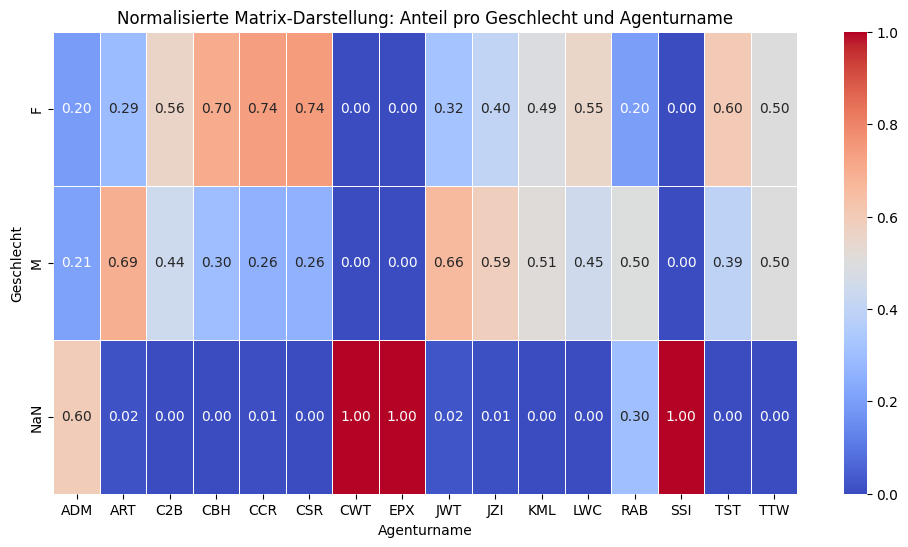

In [284]:
# Ersetzen von None durch 'NaN' für konsistente Anzeige
df["Geschlecht"] = df["Geschlecht"].fillna("NaN")

# Berechnung der Rohanzahlen pro Agentur und Geschlecht
matrix_data = df.pivot_table(index="Geschlecht", columns="Agenturname", aggfunc="size", fill_value=0)

# Normalisierung innerhalb jeder Agentur (Spaltenweise Normierung)
matrix_data_normalized = matrix_data.div(matrix_data.sum(axis=0), axis=1)

# Erstellen der Heatmap mit normalisierten Werten
plt.figure(figsize=(12, 6))
sns.heatmap(matrix_data_normalized, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Titel und Achsenbeschriftungen setzen
plt.title("Normalisierte Matrix-Darstellung: Anteil pro Geschlecht und Agenturname")
plt.xlabel("Agenturname")
plt.ylabel("Geschlecht")

# Anzeige der Heatmap
plt.show()



---
Da eine hohe Korrelation zwischen Produktname und Agenturname besteht wird diese Abhängigkeit anhand einer Matrix untersucht. Diese zeigt den Anteil der Produkte innerhalb einer Agentur (von unten nach oben lesen)
-> Einige Agenturen beinhalten hauptsächlich 1 Produkt
-> Die meisten Produkte sind nur in einer Agentur aufgelistet
-> Value Plan und Comprehensive Plan sind in mehreren Agenturen vorhanden

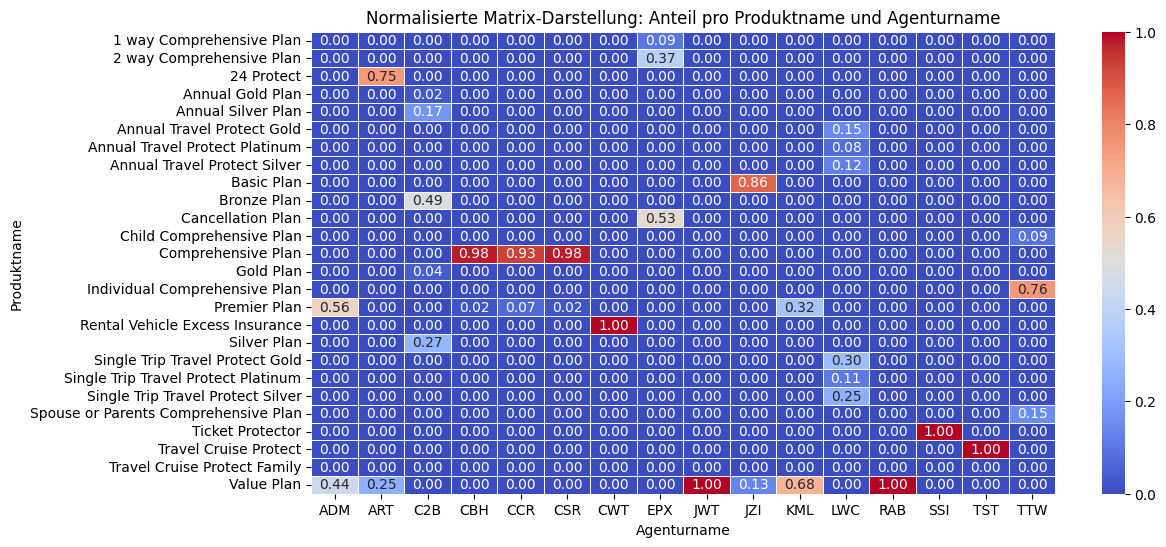

In [285]:

# Berechnung der Rohanzahlen pro Agentur und Produktname
matrix_data = df.pivot_table(index="Produktname", columns="Agenturname", aggfunc="size", fill_value=0)

# Normalisierung innerhalb jeder Agentur (Spaltenweise Normierung)
matrix_data_normalized = matrix_data.div(matrix_data.sum(axis=0), axis=1)

# Erstellen der Heatmap mit normalisierten Werten
plt.figure(figsize=(12, 6))
sns.heatmap(matrix_data_normalized, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Titel und Achsenbeschriftungen setzen
plt.title("Normalisierte Matrix-Darstellung: Anteil pro Produktname und Agenturname")
plt.xlabel("Agenturname")
plt.ylabel("Produktname")

# Anzeige der Heatmap
plt.show()



---
Da im Report gesehen wurde dass ziwschen den Features Produktname und Kommission eine hohe Korrelation besteht wurde diese näher betrachtet

-> Manche Produkte beinhalten im Durchschnitt gar keine Komission, wohingegen andere Produkte eine sehr hohe Kommission mitsichbringen
-> Die Mittelwerte der Kommission pro Produktname zeigen einen signifikanten unterschied





<ipython-input-286-42ab06fa250e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Produktname", y="Kommission", data=df, palette="viridis")


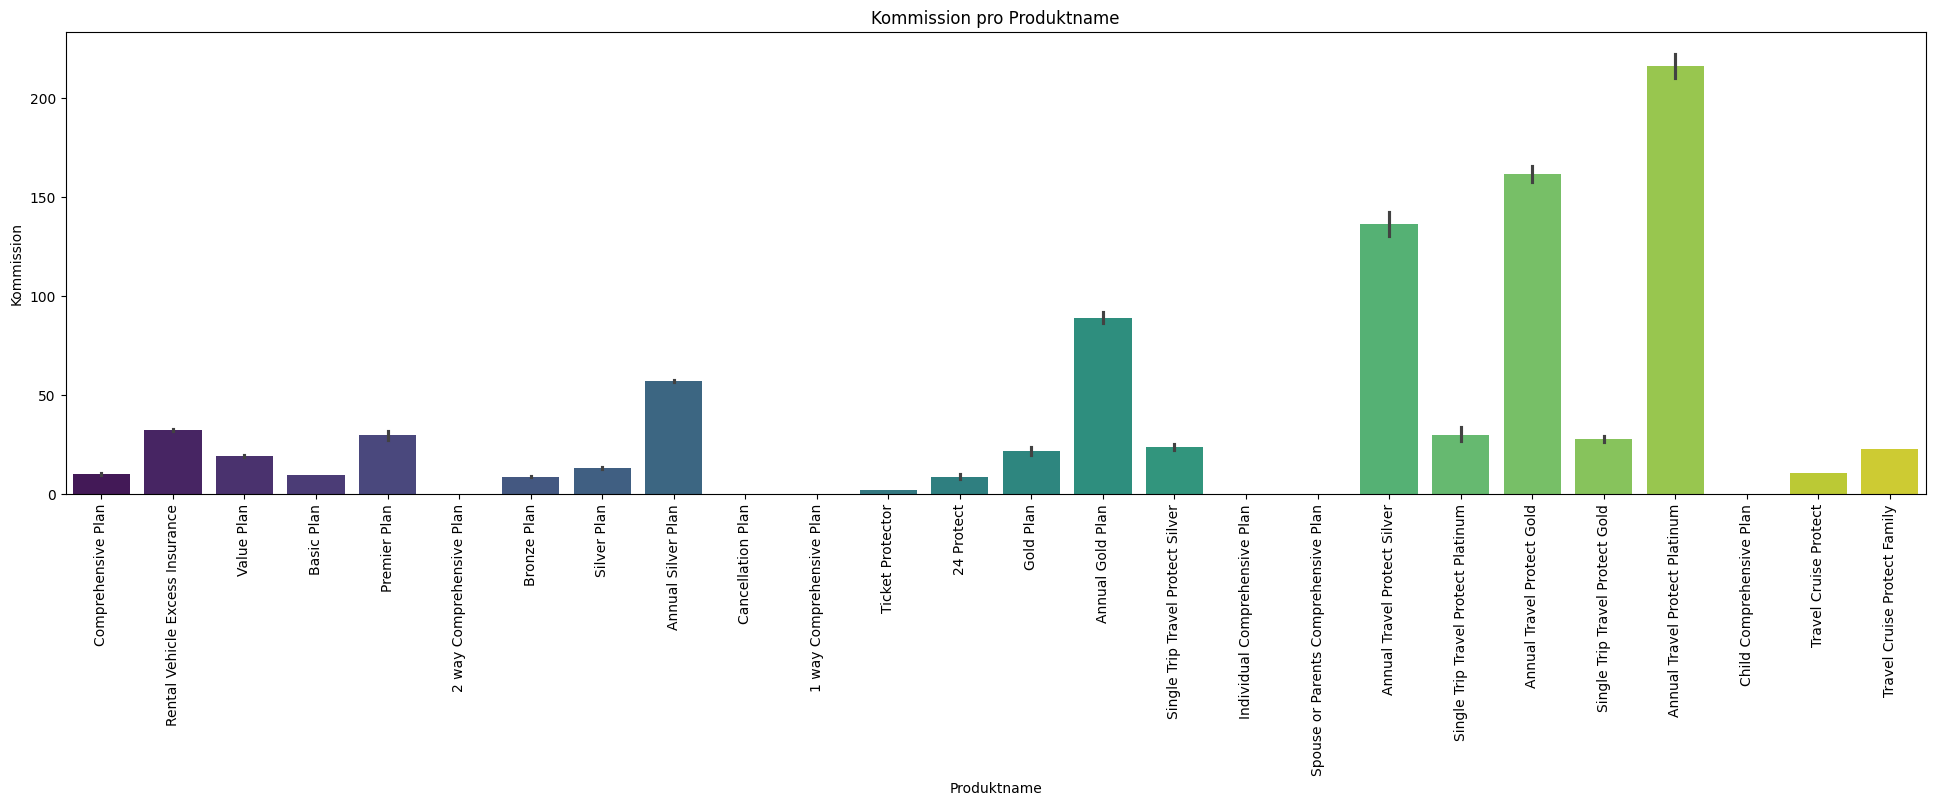

In [286]:
# Erstellen des Boxplots zur Visualisierung der Kommission pro Produktname
plt.figure(figsize=(24,6))
sns.barplot(x="Produktname", y="Kommission", data=df, palette="viridis")

# Titel und Achsenbeschriftungen setzen
plt.xticks(rotation=90)

plt.xlabel("Produktname")
plt.ylabel("Kommission")
plt.title("Kommission pro Produktname")

# Anzeige des Plots
plt.show()



---
Da im Report analysiert wurde, dass eine hohe Korrelation zwischen Nettoumsatz und Komission besteht und die beiden Features ebenfalls mit Produktname hoch korrellieren wurde dies näher betrachtet
-> Kommission solle prozenturaler Anteil am Umsatz
-> Umsatz/Komission ist abhängig vom Produkt


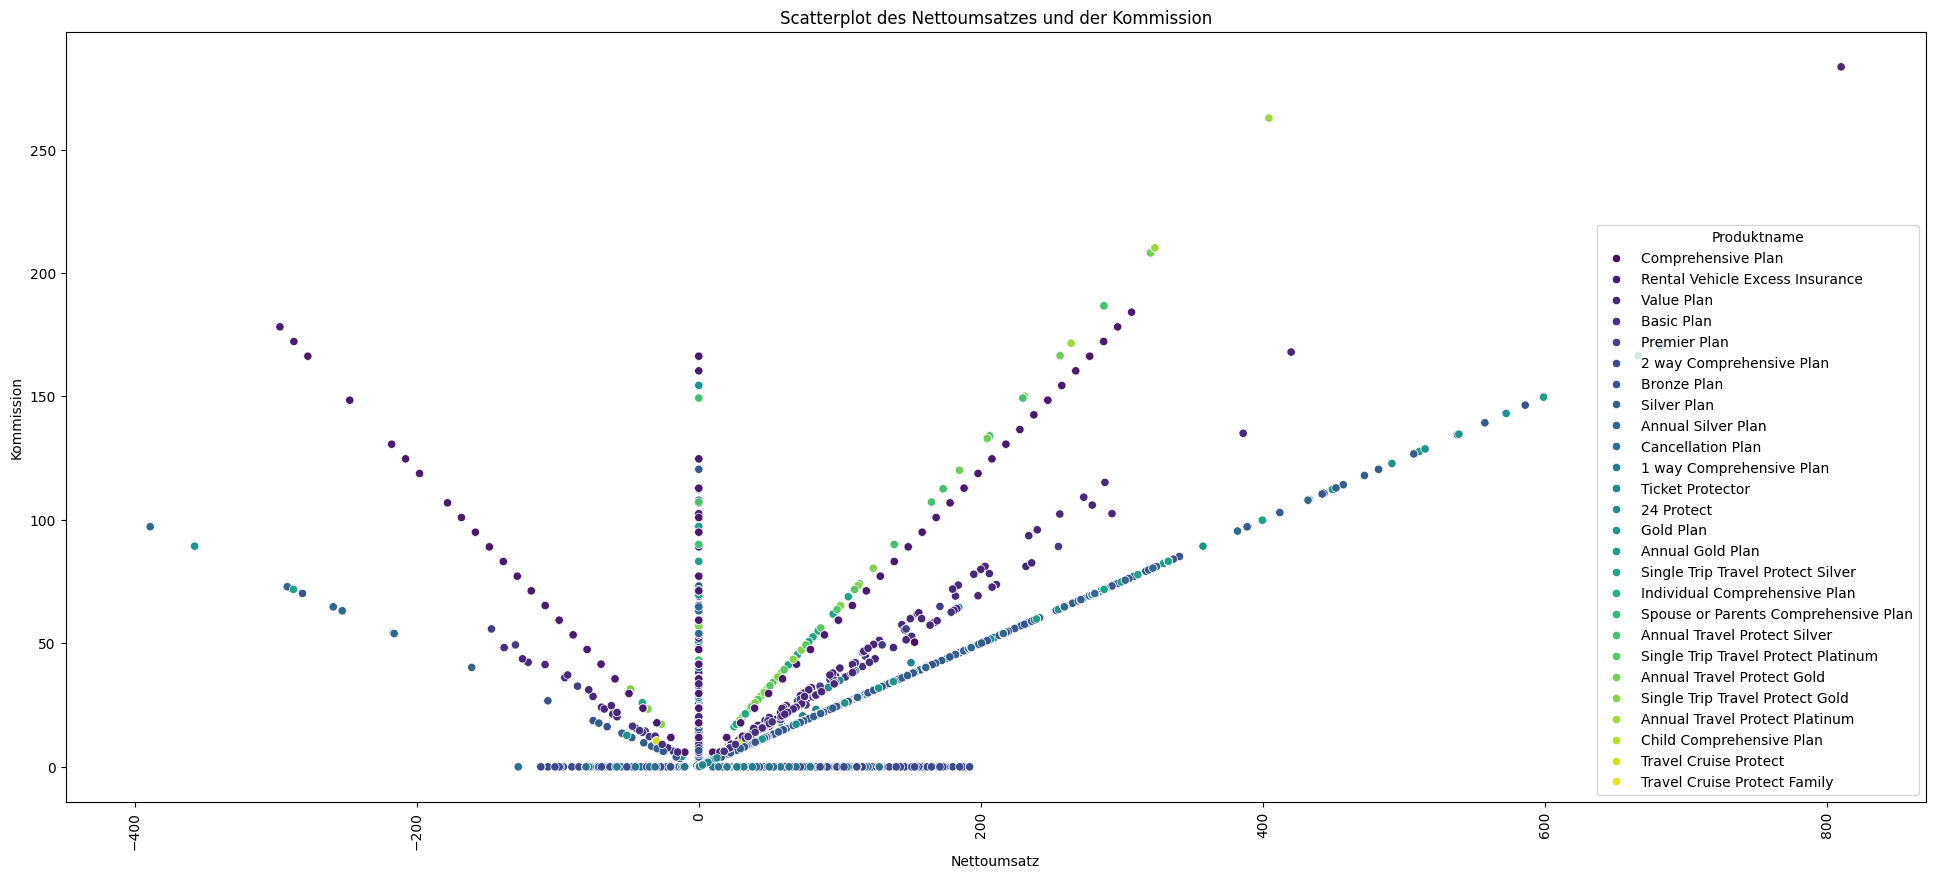

In [287]:
# Erstellen des Boxplots zur Visualisierung des Nettoumsatz pro Produktname
plt.figure(figsize=(24,10))
sns.scatterplot(x="Nettoumsatz", y="Kommission", hue="Produktname", data=df, palette="viridis")

# Titel und Achsenbeschriftungen setzen
plt.xticks(rotation=90)
plt.xlabel("Nettoumsatz")
plt.ylabel("Kommission")
plt.title("Scatterplot des Nettoumsatzes und der Kommission")

# Anzeige des Plots
plt.show()

---
Um Ausreißer, Verteilungen und Symmetrien in den numerischen Features zu untersuchen wurde individuelle Boxplots für jedes dieser Features erstellt.



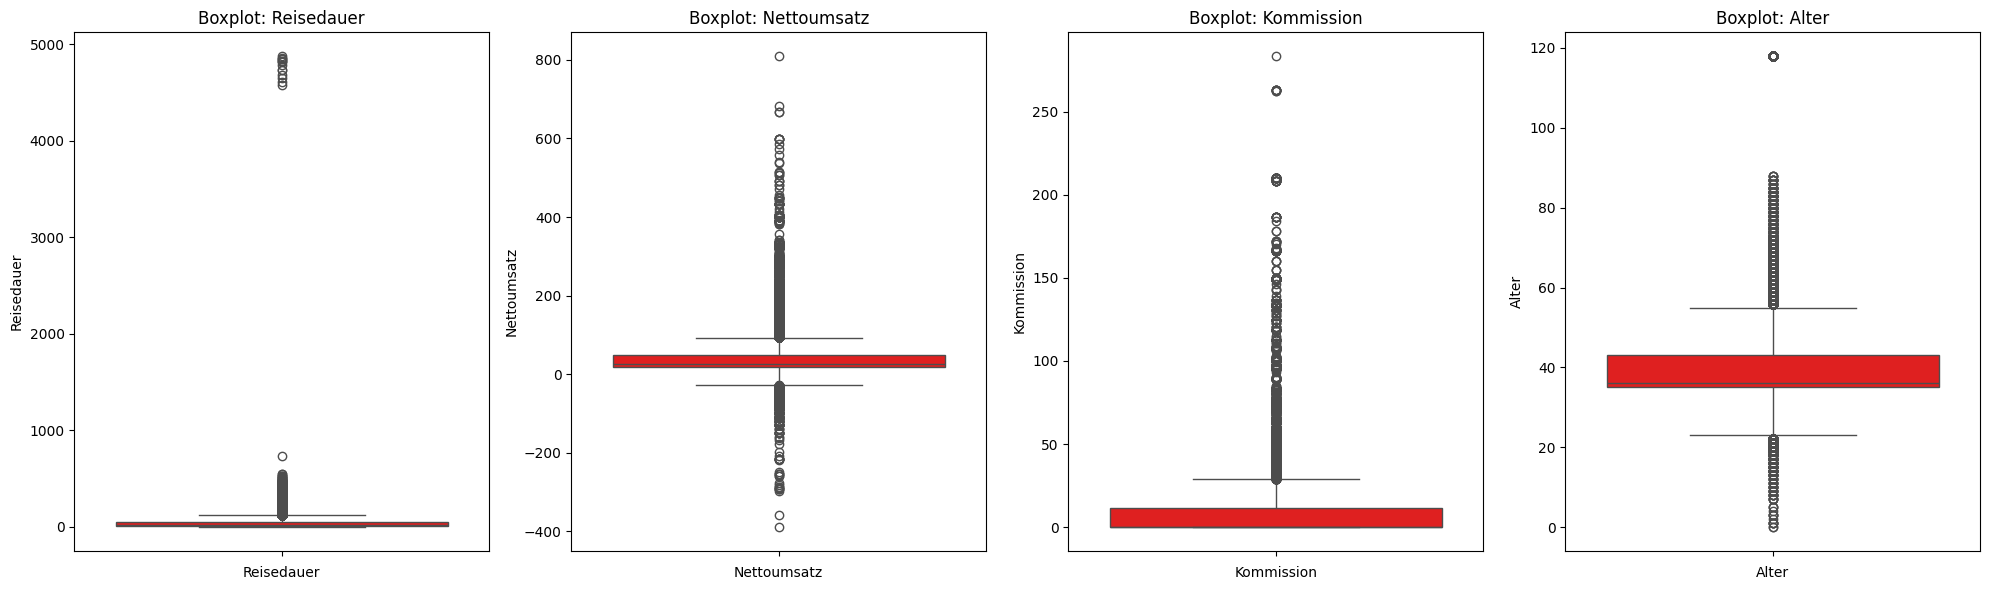

In [288]:
# Erstellen von individuellen Boxplots für jede numerische Variable
num_features = df.select_dtypes(include=['number']).columns

# Anzahl der numerischen Features für das Layout berechnen
num_features_count = len(num_features)
fig, axes = plt.subplots(nrows=1, ncols=num_features_count, figsize=(5*num_features_count, 6))

# Falls es nur ein numerisches Feature gibt, Liste umwandeln, um Fehler zu vermeiden
if num_features_count == 1:
    axes = [axes]

# Erstellen der individuellen Boxplots pro Feature
for i, feature in enumerate(num_features):
    sns.boxplot(y=df[feature], ax=axes[i], color="red")
    axes[i].set_title(f"Boxplot: {feature}")
    axes[i].set_xlabel(feature)

# Anzeige des Plots
plt.tight_layout()
plt.show()


---
Da im Report und in der tieferen Analyse beobachtet wurde, dass das Feature Reisedauer rechtsverteilt ist aber nicht gut erkennbar ist, wurde dies näher betrachtet
-> Durch die logarithmierung der x-Achse kann die Verteilung besser visualisiert werden


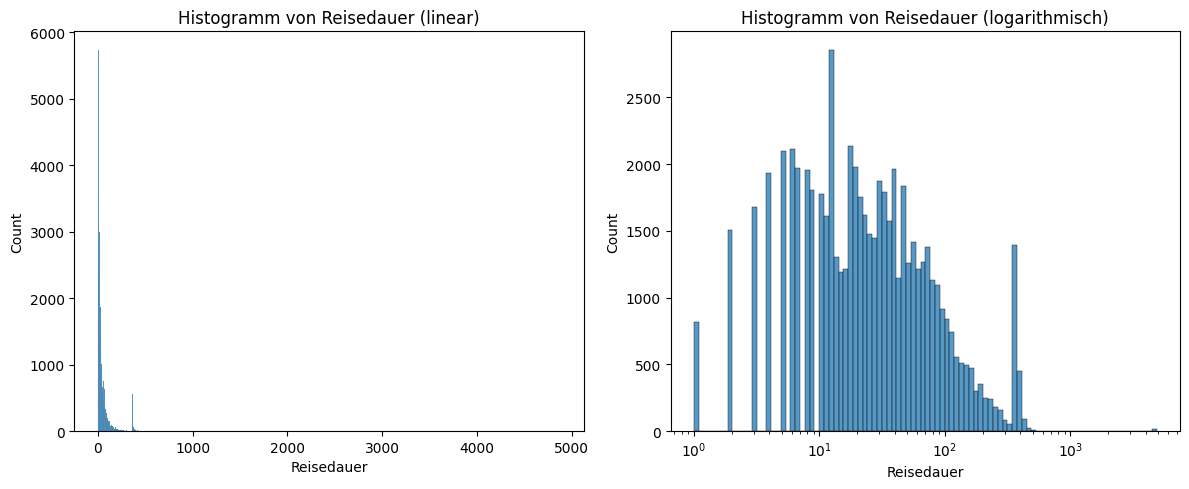

In [289]:
# Erstelle die Subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 Zeile, 2 Spalten

# Lineares Histogramm (links)
sns.histplot(data=df, x='Reisedauer', ax=axes[0])
axes[0].set_title("Histogramm von Reisedauer (linear)")

# Logarithmisches Histogramm (rechts)
sns.histplot(data=df, x='Reisedauer', log_scale=True, ax=axes[1])
axes[1].set_title("Histogramm von Reisedauer (logarithmisch)")

# Layout-Anpassung
plt.tight_layout()
plt.show()


Da im Report (wenige) negative Werte für den Nettoumsatz beobachtet wurden und der Nettoumsatz mit dem Agenturname stark korreliert wurde dies näher betrachtet
-> Einige Agenturen weisen (zwar selten) einen negativen Umsatz auf. In der Agentur ADM kann dies häufiger boebachtet werden (17%)
-> Es sollte geprüft werden wie ein negativer Umsatz zustande kommt und was dies bedeutet

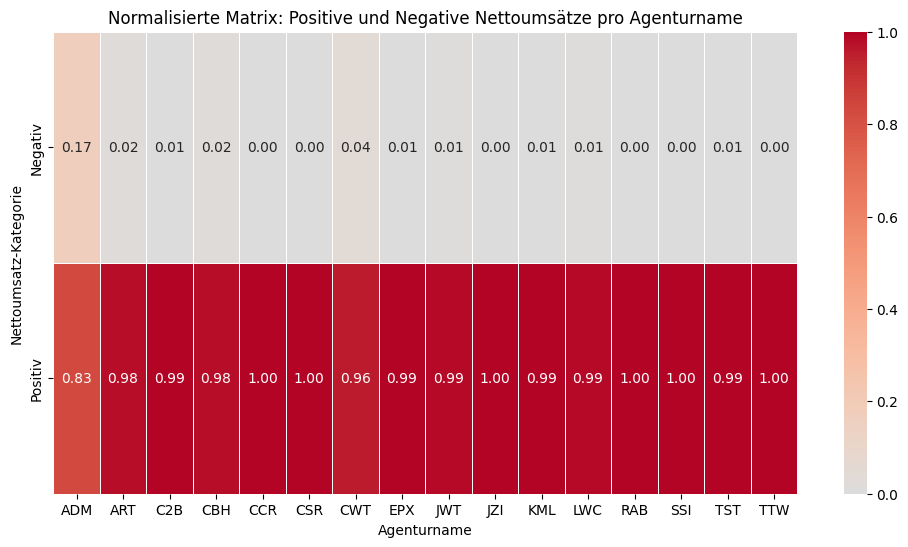

In [290]:
# Berechnung der Anzahl positiver und negativer Nettoumsätze pro Agentur
df["Nettoumsatz_kategorie"] = df["Nettoumsatz"].apply(lambda x: "Positiv" if x >= 0 else "Negativ")

# Pivot-Tabelle erstellen (absolute Werte)
matrix_data = df.pivot_table(index="Nettoumsatz_kategorie", columns="Agenturname", aggfunc="size", fill_value=0)

# Normalisierung innerhalb jeder Agentur (Spaltenweise Normierung)
matrix_data_normalized = matrix_data.div(matrix_data.sum(axis=0), axis=1)

# Erstellen der Heatmap mit normalisierten Werten
plt.figure(figsize=(12, 6))
sns.heatmap(matrix_data_normalized, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, center=0)

df = df.drop(columns="Nettoumsatz_kategorie")

# Titel und Achsenbeschriftungen setzen
plt.title("Normalisierte Matrix: Positive und Negative Nettoumsätze pro Agenturname")
plt.xlabel("Agenturname")
plt.ylabel("Nettoumsatz-Kategorie")

# Anzeige der Heatmap
plt.show()


Da im SweetViz Report die Pearson Korrelation verwendet wurde, wird nun ebenfalls die Spearman Korrelation betrachtet
- Pearson Korrelation zeigt lineare Zusammenhänge (Metrische Daten)
- Spearman Korrelation zeigt nichtlineare (monotone) Zusammenhänge und betrachtet Korrelaten der Ränge der Werte (Auch ordinale Daten)

-> Es können keine nicht-linearen Zusammenhänge festgestellt werden


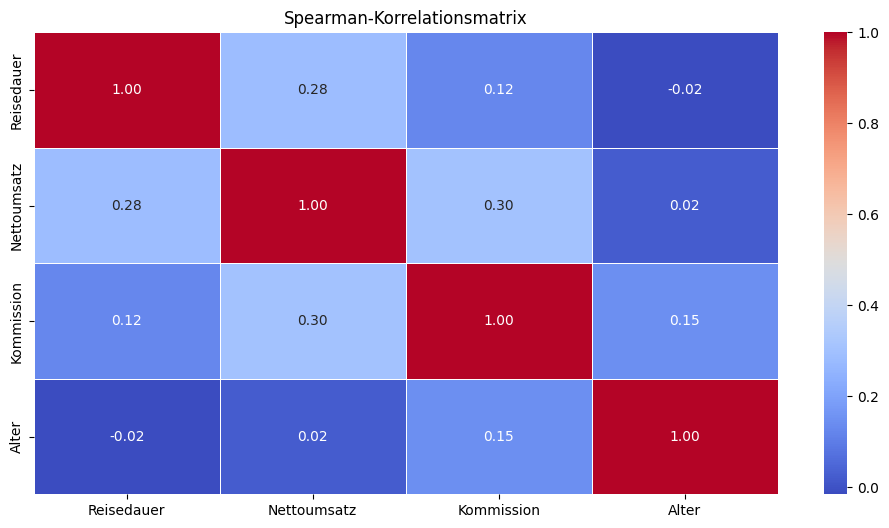

In [291]:
# Auswahl der numerischen Spalten
numeric_df = df.select_dtypes(include=["number"])

# Spearman-Korrelationsmatrix berechnen
if not numeric_df.empty:
    spearman_corr_matrix = numeric_df.corr(method="spearman")

    # Visualisierung der Spearman-Korrelation als Heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(spearman_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

    # Titel setzen
    plt.title("Spearman-Korrelationsmatrix")
    plt.show()
else:
    print("Keine numerischen Spalten im DataFrame vorhanden. Korrelation kann nicht berechnet werden.")



In [293]:
# Liste der kategorischen Features (die, die One-Hot-Encoding bekommen)
categorical_features = ["Agenturname", "Agenturtyp", "Vertriebskanal", "Produktname", "Geschlecht"]


In [294]:
#df_fe = df.copy()

In [295]:
def cramers_v(x, y):
    """Berechnet Cramér's V für zwei kategoriale Variablen."""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Erstelle eine leere Matrix für Cramér's V-Werte
cramers_v_matrix = pd.DataFrame(index=categorical_features, columns=categorical_features, dtype=float)

# Berechne Cramér's V für alle kategorialen Variablen
for col1 in categorical_features:
    for col2 in categorical_features:
        if col1 != col2:
            cramers_v_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

# Ausgabe der Matrix
print(cramers_v_matrix)


                Agenturname  Agenturtyp  Vertriebskanal  Produktname  \
Agenturname             NaN    0.999889        0.952955     0.798835   
Agenturtyp         0.999889         NaN        0.076658     0.988874   
Vertriebskanal     0.952955    0.076658             NaN     0.945704   
Produktname        0.798835    0.988874        0.945704          NaN   
Geschlecht         0.711783    0.864865        0.197584     0.710870   

                Geschlecht  
Agenturname       0.711783  
Agenturtyp        0.864865  
Vertriebskanal    0.197584  
Produktname       0.710870  
Geschlecht             NaN  


In [296]:
# Stark korrelierte Kategorien herausfiltern (z. B. > 0.8)
high_corr_categories = [(col1, col2) for col1 in categorical_features for col2 in categorical_features
                        if col1 != col2 and cramers_v_matrix.loc[col1, col2] > 0.8]

print("Stark korrelierte kategoriale Feature-Paare:")
for feature1, feature2 in high_corr_categories:
    print(f"{feature1} ↔ {feature2} (Cramér's V > 0.8)")

Stark korrelierte kategoriale Feature-Paare:
Agenturname ↔ Agenturtyp (Cramér's V > 0.8)
Agenturname ↔ Vertriebskanal (Cramér's V > 0.8)
Agenturtyp ↔ Agenturname (Cramér's V > 0.8)
Agenturtyp ↔ Produktname (Cramér's V > 0.8)
Agenturtyp ↔ Geschlecht (Cramér's V > 0.8)
Vertriebskanal ↔ Agenturname (Cramér's V > 0.8)
Vertriebskanal ↔ Produktname (Cramér's V > 0.8)
Produktname ↔ Agenturtyp (Cramér's V > 0.8)
Produktname ↔ Vertriebskanal (Cramér's V > 0.8)
Geschlecht ↔ Agenturtyp (Cramér's V > 0.8)


# Datenvorverarbeitung Generell

Im ersten Schritt werden die Daten grundlegend vorbereitet.

Folgende Schritte werden durchgeführt:

- Umwandlung der Werte von Leistungseintritt in 0 und 1 statt No und Yes
- Definition der Zielvariable y (Leistungseintritt) und den Featues X (alle anderen Merkmale)
- Aufteilen der Daten in Trainings- und Testdaten
-> Da unbalanced Data wurde nach Produktname und Leistungseintritt stratifiziert, um zu verhindern, dass seltene Kombination nur in einem Set landen



In [297]:
# Umwandlung von "yes" zu 1 und "no" zu 0
df["Leistungseintritt"] = df["Leistungseintritt"].map({"Yes": 1, "No": 0})

In [298]:
# Liste der zu entfernenden Features
#features_to_drop = [ "Vertriebskanal", "Agenturtyp", "Geschlecht", "Agenturname"]

# Entfernen der Features aus X_train und X_test
#df_fe = df_fe.drop(columns=features_to_drop)


#print(f"Anzahl der Features nach Reduktion: {df_fe.shape[1]}")

In [299]:
df

,Agenturname,Agenturtyp,Vertriebskanal,Produktname,Leistungseintritt,Reisedauer,Reiseziel,Nettoumsatz,Kommission,Geschlecht,Alter
0,CBH,Travel Agency,Offline,Comprehensive Plan,0,186,MALAYSIA,-29.0,9.57,F,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,0,186,MALAYSIA,-29.0,9.57,F,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,0,65,AUSTRALIA,-49.5,29.70,NaN,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,0,60,AUSTRALIA,-39.6,23.76,NaN,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,0,79,ITALY,-19.8,11.88,NaN,41
...,...,...,...,...,...,...,...,...,...,...,...
63321,JZI,Airlines,Online,Basic Plan,0,111,JAPAN,35.0,12.25,M,31
63322,JZI,Airlines,Online,Basic Plan,0,58,CHINA,40.0,14.00,F,40
63323,JZI,Airlines,Online,Basic Plan,0,2,MALAYSIA,18.0,6.30,M,57
63324,JZI,Airlines,Online,Basic Plan,0,3,VIET NAM,18.0,6.30,M,63


Features und Zielvariable definieren

In [300]:
X = df.drop(columns=["Leistungseintritt"])  # Unabhängige Variablen (alle außer Leistungseintritt)
y = df["Leistungseintritt"]  # Zielvariable (Yes/No)

In [301]:
y

,Leistungseintritt
0,0
1,0
2,0
3,0
4,0
...,...
63321,0
63322,0
63323,0
63324,0


Train Test Split  

In [302]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


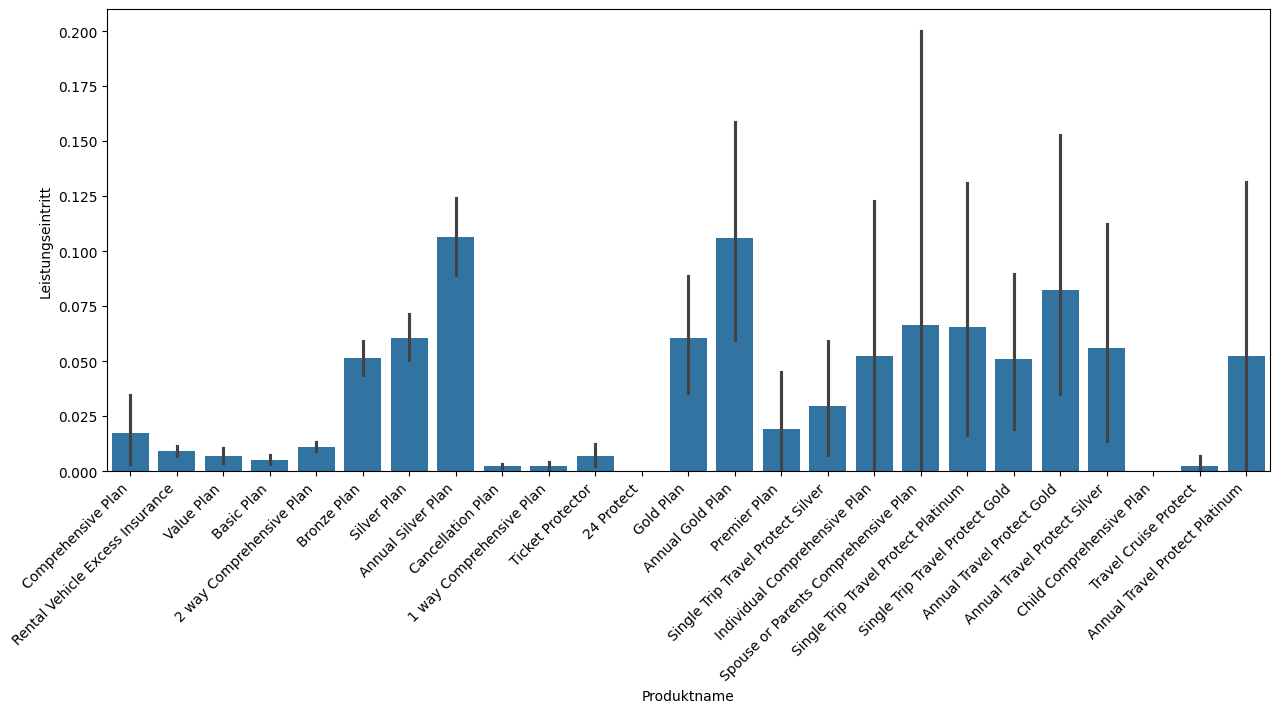

In [303]:
# Produktnamen alphabetisch sortieren
sorted_productnames = sorted(X_train["Produktname"].unique())

# Erstellen des Barplots mit sortierter X-Achse
plt.figure(figsize=(15,6))
plt.xticks(rotation=45, ha='right')

sns.barplot(
    data=X_train.sort_values("Produktname"),  # Sortiere nach Produktname
    x="Produktname",
    y=y_train
)

plt.show()


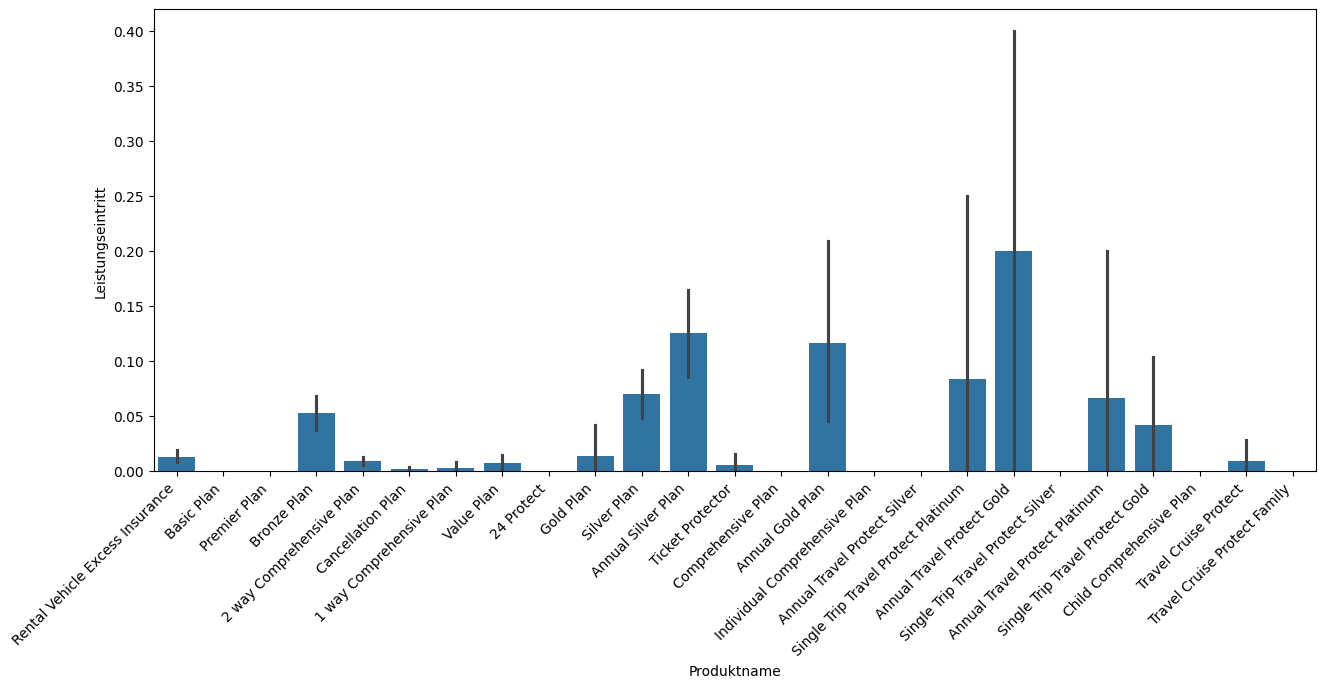

In [304]:
# Produktnamen alphabetisch sortieren
sorted_productnames = sorted(X_test["Produktname"].unique())

# Erstellen des Barplots mit sortierter X-Achse
plt.figure(figsize=(15,6))
plt.xticks(rotation=45, ha='right')

sns.barplot(
    data=X_test.sort_values("Produktname"),  # Sortiere nach Produktname
    x="Produktname",
    y=y_test
)

plt.show()


In [305]:
# 1️⃣ Erstellen einer kombinierten Kategorie aus Produktname & Leistungseintritt
X["stratify_group"] = X["Produktname"].astype(str) + "_" + y.astype(str)

# 2️⃣ Zählen, wie oft jede Kombination vorkommt
group_counts = X["stratify_group"].value_counts()

# 3️⃣ Seltene Kombinationen (nur 1-mal vorkommend) identifizieren
rare_groups = group_counts[group_counts == 1].index

# 4️⃣ Diese seltenen Kombinationen zufällig einer anderen Gruppe zuweisen
np.random.seed(42)  # Für reproduzierbare Ergebnisse
random_choices = np.random.choice(group_counts[group_counts > 1].index, size=len(rare_groups))
replacement_dict = dict(zip(rare_groups, random_choices))

# 5️⃣ Falls eine Gruppe zu selten ist, ersetze sie mit einer zufälligen häufigen Gruppe
X["stratify_final"] = X["stratify_group"].replace(replacement_dict)

# 6️⃣ Train-Test-Split mit neuer stratifizierter Variable
X_train, X_test, y_train, y_test = train_test_split(
    X.drop(columns=["stratify_group", "stratify_final"]),  # Entferne die Hilfsspalten
    y,
    test_size=0.2,
    random_state=42,
    stratify=X["stratify_final"]  # Jetzt sind Produktname & y beide berücksichtigt
)



<ipython-input-306-87d3731d128d>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


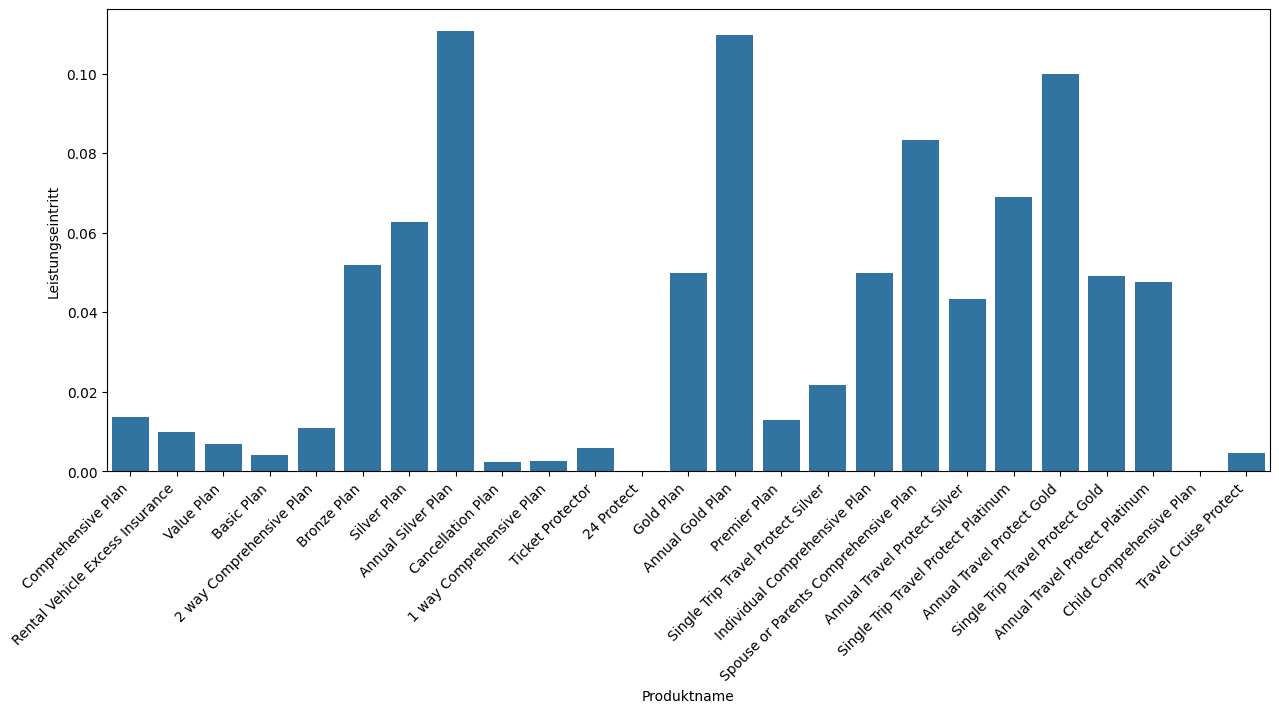

In [306]:
# Produktnamen alphabetisch sortieren
sorted_productnames = sorted(X_train["Produktname"].unique())

# Erstellen des Barplots mit sortierter X-Achse
plt.figure(figsize=(15,6))
plt.xticks(rotation=45, ha='right')

sns.barplot(
    data=X_train.sort_values("Produktname"),  # Sortiere nach Produktname
    x="Produktname",
    y=y_train,
    ci=None
)

plt.show()

<ipython-input-307-3bb9d2b4403b>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


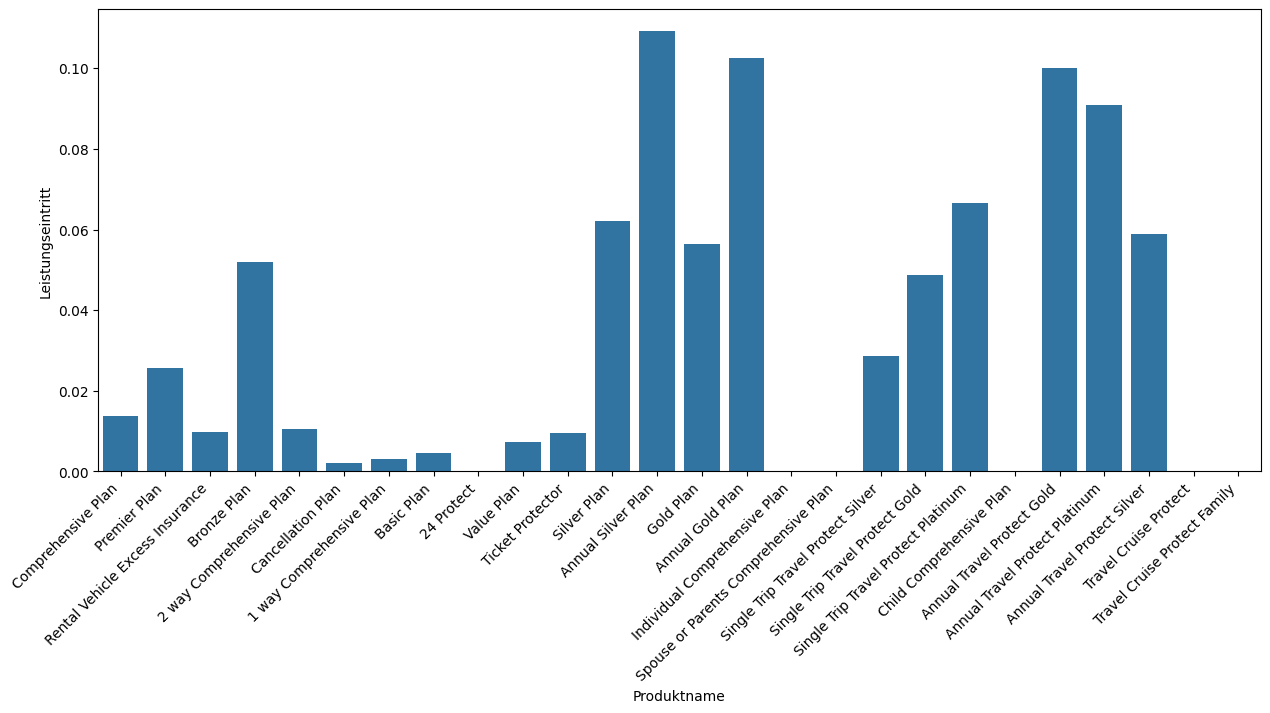

In [307]:
# Produktnamen alphabetisch sortieren
sorted_productnames = sorted(X_test["Produktname"].unique())

# Erstellen des Barplots mit sortierter X-Achse
plt.figure(figsize=(15,6))
plt.xticks(rotation=45, ha='right')

sns.barplot(
    data=X_test.sort_values("Produktname"),  # Sortiere nach Produktname
    x="Produktname",
    y=y_test,
    ci=None
)

plt.show()

# Baseline Model: Logistische Regression

Die logistische Regression dient als Baseline Model da:
- einfach zu interpretieren
- Vergleichswert für komplexere Modelle

## Datenvorverarbeitung für Logistische Regression

Die Daten werden folgendermaßen vorbereitet:

- Entfernen der Features, die keine zusätzlichen Informationen liefern um Multikollinearität zu vermeiden
- One-Hot-Encoding der kategorialen Features (Außer Reiseziel, da zu viele Ausprägungen -> Könnte zu Multikollinearität führen)
- Feature Reiseziel: Seltene Reiseziele werden in Kategorie "Sonstige" zusammengefasst, um Anzahl der Dummy-Variablen beim One-Hot-Encoding zu reduzieren; danach One-Hot-Encoding
- Skalieren der numerischen Features um diese auf eine vergleichbare Skala zu bringen

In [308]:
# Drop irrelevante Features
# Liste der zu entfernenden Features
features_to_drop = [ "Vertriebskanal", "Agenturtyp", "Geschlecht", "Agenturname", "Kommission"]

# Entfernen der Features aus X_train und X_test

X_train_lg = X_train.drop(columns=features_to_drop)
X_test_lg = X_test.drop(columns=features_to_drop)
y_train_lg = y_train.drop(columns=features_to_drop)
y_test_lg = y_test.drop(columns=features_to_drop)

X_train_lg

,Produktname,Reisedauer,Reiseziel,Nettoumsatz,Alter
36982,2 way Comprehensive Plan,33,CHINA,30.0,36
35609,Value Plan,22,BRUNEI DARUSSALAM,50.0,28
58659,Cancellation Plan,11,SINGAPORE,40.0,35
18400,2 way Comprehensive Plan,38,MALAYSIA,20.0,28
27520,Cancellation Plan,24,SINGAPORE,25.0,36
...,...,...,...,...,...
14827,2 way Comprehensive Plan,34,CHINA,30.0,36
21196,Rental Vehicle Excess Insurance,22,DENMARK,49.5,50
46854,Cancellation Plan,62,THAILAND,80.0,37
32266,2 way Comprehensive Plan,55,NETHERLANDS,98.0,36


One-Hot-Encoding der kategorialen Features (außer Reiseziel -> Zu viele neue Features)

In [309]:
X_train_encoded = pd.get_dummies(X_train_lg, columns=["Produktname"], drop_first=True)
X_train_encoded

,Reisedauer,Reiseziel,Nettoumsatz,Alter,Produktname_2 way Comprehensive Plan,Produktname_24 Protect,Produktname_Annual Gold Plan,Produktname_Annual Silver Plan,Produktname_Annual Travel Protect Gold,Produktname_Annual Travel Protect Platinum,...,Produktname_Premier Plan,Produktname_Rental Vehicle Excess Insurance,Produktname_Silver Plan,Produktname_Single Trip Travel Protect Gold,Produktname_Single Trip Travel Protect Platinum,Produktname_Single Trip Travel Protect Silver,Produktname_Spouse or Parents Comprehensive Plan,Produktname_Ticket Protector,Produktname_Travel Cruise Protect,Produktname_Value Plan
36982,33,CHINA,30.0,36,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
35609,22,BRUNEI DARUSSALAM,50.0,28,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
58659,11,SINGAPORE,40.0,35,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
18400,38,MALAYSIA,20.0,28,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
27520,24,SINGAPORE,25.0,36,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14827,34,CHINA,30.0,36,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
21196,22,DENMARK,49.5,50,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
46854,62,THAILAND,80.0,37,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
32266,55,NETHERLANDS,98.0,36,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Verarbeiten des Features Reiseziel

In [310]:
threshold = 0.01  # Setze die Schwelle auf 1% der Daten (anpassbar)

# Berechne die Häufigkeit jedes Reiseziels
reiseziel_counts = X_train_encoded['Reiseziel'].value_counts(normalize=True)

# Markiere seltene Reiseziele als 'Sonstige'
seltene_ziele = reiseziel_counts[reiseziel_counts < threshold].index
X_train_encoded['Reiseziel_kategorisiert'] = X_train_encoded['Reiseziel'].replace(seltene_ziele, 'Sonstige')

# Ursprüngliche "Reiseziel"-Spalte entfernen
X_train_encoded.drop(columns=['Reiseziel'], inplace=True, errors='ignore')

# One-Hot-Encoding der neuen Kategorie
X_train_encoded = pd.get_dummies(X_train_encoded, columns=['Reiseziel_kategorisiert'])

# Überprüfe die neue Anzahl der Spalten
print(X_train_encoded.shape)

(50660, 45)


In [311]:
X_train_encoded

,Reisedauer,Nettoumsatz,Alter,Produktname_2 way Comprehensive Plan,Produktname_24 Protect,Produktname_Annual Gold Plan,Produktname_Annual Silver Plan,Produktname_Annual Travel Protect Gold,Produktname_Annual Travel Protect Platinum,Produktname_Annual Travel Protect Silver,...,Reiseziel_kategorisiert_JAPAN,Reiseziel_kategorisiert_MALAYSIA,Reiseziel_kategorisiert_MYANMAR,Reiseziel_kategorisiert_PHILIPPINES,Reiseziel_kategorisiert_SINGAPORE,Reiseziel_kategorisiert_Sonstige,Reiseziel_kategorisiert_THAILAND,Reiseziel_kategorisiert_UNITED KINGDOM,Reiseziel_kategorisiert_UNITED STATES,Reiseziel_kategorisiert_VIET NAM
36982,33,30.0,36,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
35609,22,50.0,28,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
58659,11,40.0,35,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
18400,38,20.0,28,True,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
27520,24,25.0,36,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14827,34,30.0,36,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
21196,22,49.5,50,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
46854,62,80.0,37,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
32266,55,98.0,36,True,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [312]:
X_train

,Agenturname,Agenturtyp,Vertriebskanal,Produktname,Reisedauer,Reiseziel,Nettoumsatz,Kommission,Geschlecht,Alter
36982,EPX,Travel Agency,Online,2 way Comprehensive Plan,33,CHINA,30.0,0.0,NaN,36
35609,RAB,Airlines,Online,Value Plan,22,BRUNEI DARUSSALAM,50.0,20.0,M,28
58659,EPX,Travel Agency,Online,Cancellation Plan,11,SINGAPORE,40.0,0.0,NaN,35
18400,EPX,Travel Agency,Online,2 way Comprehensive Plan,38,MALAYSIA,20.0,0.0,NaN,28
27520,EPX,Travel Agency,Online,Cancellation Plan,24,SINGAPORE,25.0,0.0,NaN,36
...,...,...,...,...,...,...,...,...,...,...
14827,EPX,Travel Agency,Online,2 way Comprehensive Plan,34,CHINA,30.0,0.0,NaN,36
21196,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,22,DENMARK,49.5,29.7,NaN,50
46854,EPX,Travel Agency,Online,Cancellation Plan,62,THAILAND,80.0,0.0,NaN,37
32266,EPX,Travel Agency,Online,2 way Comprehensive Plan,55,NETHERLANDS,98.0,0.0,NaN,36


In [313]:
# Alle bool-Spalten in 0 und 1 konvertieren
X_train_encoded = X_train_encoded.astype(int)

In [314]:
X_train_encoded

,Reisedauer,Nettoumsatz,Alter,Produktname_2 way Comprehensive Plan,Produktname_24 Protect,Produktname_Annual Gold Plan,Produktname_Annual Silver Plan,Produktname_Annual Travel Protect Gold,Produktname_Annual Travel Protect Platinum,Produktname_Annual Travel Protect Silver,...,Reiseziel_kategorisiert_JAPAN,Reiseziel_kategorisiert_MALAYSIA,Reiseziel_kategorisiert_MYANMAR,Reiseziel_kategorisiert_PHILIPPINES,Reiseziel_kategorisiert_SINGAPORE,Reiseziel_kategorisiert_Sonstige,Reiseziel_kategorisiert_THAILAND,Reiseziel_kategorisiert_UNITED KINGDOM,Reiseziel_kategorisiert_UNITED STATES,Reiseziel_kategorisiert_VIET NAM
36982,33,30,36,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35609,22,50,28,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58659,11,40,35,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
18400,38,20,28,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
27520,24,25,36,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14827,34,30,36,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21196,22,49,50,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
46854,62,80,37,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
32266,55,98,36,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [315]:
# Liste der ursprünglichen kategorialen Spalten vor dem Encoding
categorical_columns = ["Reiseziel", "Agenturname", "Agenturtyp", "Vertriebskanal", "Produktname", "Geschlecht"]

# Ursprüngliche Anzahl der kategorialen Spalten
num_columns_before = len(categorical_columns)

# Anzahl der Spalten nach One-Hot-Encoding
num_columns_after = X_train_encoded.shape[1]

# Berechnung der zusätzlichen Spalten je Feature basierend auf X_train_encoded
added_columns_per_feature = {
    col: len([c for c in X_train_encoded.columns if c.startswith(col + "_")])
    for col in categorical_columns
}

# Ausgabe der Ergebnisse
print(f"Anzahl der Spalten vor One-Hot-Encoding: {num_columns_before}")
print(f"Anzahl der Spalten nach One-Hot-Encoding: {num_columns_after}")
print("Zusätzliche Spalten durch Encoding je Feature:")
for feature, count in added_columns_per_feature.items():
    print(f" - {feature}: +{count} Spalten")

Anzahl der Spalten vor One-Hot-Encoding: 6
Anzahl der Spalten nach One-Hot-Encoding: 45
Zusätzliche Spalten durch Encoding je Feature:
 - Reiseziel: +18 Spalten
 - Agenturname: +0 Spalten
 - Agenturtyp: +0 Spalten
 - Vertriebskanal: +0 Spalten
 - Produktname: +24 Spalten
 - Geschlecht: +0 Spalten


Vorverarbeitung X_test_encoded auf die gleiche Art

In [316]:
# Gleiche Reiseziel-Kategorisierung auf X_test anwenden
X_test_encoded = X_test_lg.copy()

# Ersetze seltene Reiseziele in X_test durch 'Sonstige', basierend auf X_train
X_test_encoded['Reiseziel_kategorisiert'] = X_test_encoded['Reiseziel'].apply(
    lambda x: x if x in reiseziel_counts[reiseziel_counts >= threshold].index else 'Sonstige'
)

# One-Hot-Encoding für X_test (aber keine neuen Spalten erstellen!)
X_test_encoded = pd.get_dummies(X_test_encoded, columns=["Produktname","Reiseziel_kategorisiert"], drop_first=True)

# Fehlende Spalten in X_test hinzufügen (damit es die gleichen Spalten hat wie X_train_encoded)
missing_cols = set(X_train_encoded.columns) - set(X_test_encoded.columns)
for col in missing_cols:
    X_test_encoded[col] = 0  # Fehlende Spalten mit 0 auffüllen

# Sicherstellen, dass die Spaltenreihenfolge identisch ist
X_test_encoded = X_test_encoded[X_train_encoded.columns]

# Überprüfung der Shapes
print(f"X_train shape: {X_train_encoded.shape}")
print(f"X_test shape: {X_test_encoded.shape}")


X_train shape: (50660, 45)
X_test shape: (12666, 45)


In [317]:
X_test_encoded = X_test_encoded.astype(int)

In [318]:
X_test_encoded

,Reisedauer,Nettoumsatz,Alter,Produktname_2 way Comprehensive Plan,Produktname_24 Protect,Produktname_Annual Gold Plan,Produktname_Annual Silver Plan,Produktname_Annual Travel Protect Gold,Produktname_Annual Travel Protect Platinum,Produktname_Annual Travel Protect Silver,...,Reiseziel_kategorisiert_JAPAN,Reiseziel_kategorisiert_MALAYSIA,Reiseziel_kategorisiert_MYANMAR,Reiseziel_kategorisiert_PHILIPPINES,Reiseziel_kategorisiert_SINGAPORE,Reiseziel_kategorisiert_Sonstige,Reiseziel_kategorisiert_THAILAND,Reiseziel_kategorisiert_UNITED KINGDOM,Reiseziel_kategorisiert_UNITED STATES,Reiseziel_kategorisiert_VIET NAM
1301,41,12,36,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2018,73,20,64,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
49484,11,33,36,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8285,314,0,48,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
15922,9,20,36,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26160,4,10,43,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8770,81,20,36,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
25989,25,34,36,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46450,178,20,25,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


Skalieren der numerischen Features um diese auf eine vergleichbare Skala zu bringen

In [319]:
# Liste numerischer Features
numerical_features = ['Reisedauer', 'Nettoumsatz', 'Alter']

# Initialisiere den StandardScaler
scaler = StandardScaler()

# Fitte den Scaler nur auf X_train und wende ihn an
X_train_encoded[numerical_features] = scaler.fit_transform(X_train_encoded[numerical_features])
X_test_encoded[numerical_features] = scaler.transform(X_test_encoded[numerical_features])


In [320]:
X_train_encoded

,Reisedauer,Nettoumsatz,Alter,Produktname_2 way Comprehensive Plan,Produktname_24 Protect,Produktname_Annual Gold Plan,Produktname_Annual Silver Plan,Produktname_Annual Travel Protect Gold,Produktname_Annual Travel Protect Platinum,Produktname_Annual Travel Protect Silver,...,Reiseziel_kategorisiert_JAPAN,Reiseziel_kategorisiert_MALAYSIA,Reiseziel_kategorisiert_MYANMAR,Reiseziel_kategorisiert_PHILIPPINES,Reiseziel_kategorisiert_SINGAPORE,Reiseziel_kategorisiert_Sonstige,Reiseziel_kategorisiert_THAILAND,Reiseziel_kategorisiert_UNITED KINGDOM,Reiseziel_kategorisiert_UNITED STATES,Reiseziel_kategorisiert_VIET NAM
36982,-0.157759,-0.214870,-0.282504,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35609,-0.263996,0.193989,-0.855465,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58659,-0.370233,-0.010440,-0.354124,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
18400,-0.109470,-0.419299,-0.855465,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
27520,-0.244681,-0.317085,-0.282504,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14827,-0.148102,-0.214870,-0.282504,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21196,-0.263996,0.173546,0.720179,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
46854,0.122320,0.807278,-0.210884,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
32266,0.054714,1.175252,-0.282504,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Modelltraining

Modellinitialisierung:

max_iter=1000

random_state=42

In [321]:
#from sklearn.linear_model import LogisticRegression

# Initialisiere das Modell
#log_reg = LogisticRegression(max_iter=1000, random_state=42,class_weight='balanced')

# Trainiere das Modell
#log_reg.fit(X_train_encoded, y_train)

#print("Modelltraining abgeschlossen")


In [322]:
# Initialisiere das Modell
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Trainiere das Modell
log_reg.fit(X_train_encoded, y_train)

print("Modelltraining abgeschlossen")

Modelltraining abgeschlossen


## Vorhersage und Evaluierung der Ergebnisse

Das trainierte Modell wird nun auf ungesehene Daten angewendet und die Ergebnisse evaluiert

Evaluation NICHT mit Precision und Recall da Datensatz stark unausgeglichen ist und somit Recall zB sehr hoch sein kann weil das Modell fast immer als 0 (Kein Leistungseintritt) klassifiziert

Positiv = Leistungseintritt;
Negativ = Kein Leistungseintritt

False Positive: Als positiv vorhergesagt, tatsächlich negativ;
True Positive: Als positiv vorhergesat, tatsächlich positiv;
False Negative: Als negativ vorhergesagt, tatsächlich positiv;
True Negative: ALs negativ vorhergesagt, tatsächlich negativ


Evaluation mit:

- ROC-Kurve: Zeigt Trade-Offs zwischen Recall und False Positive Rate bei verschiedenen Schwellenwerten -> Zeigt, wie gut Modell die Klassen positiv und negativ trennen kann

- PR-Kurve: Konzentriert sich auf Klasse 1, misst wie gut Modell tatsächlich Positive von falsch positiven Trennt

- Interpretation der Koeffizienten: Zeigen wie stark und in welche Richtung ein Feature die Wahrscheinlichkeit eines Leistungseintritts beeinflusst

- Interpretation Odds-Ratio: Gibt an, um welchen Faktor sich die Warhscheinlichkeit  ändert, wenn sich ein Feature um 1 Einheit erhöht (z.B. Odds-Ratio Reisedauer: 1.2 -> Wenn Reisedauer um 1 Einheit steigt, erhöht sich Wahrscheinlichkeit Leistungseintritt um 20% (1,2 - 1 = 0,2)

OR > 1 -> höhere Wahrscheinlichkeit
OR < 1 -> niedrigere Wahrscheinlichkeit



Vorhersage berechnen

In [323]:
# Klassenvorhersagen (0 oder 1)
y_pred = log_reg.predict(X_test_encoded)

# Wahrscheinlichkeitsvorhersagen für Klasse 1 (positiv)
y_pred_proba = log_reg.predict_proba(X_test_encoded)[:, 1]

In [324]:
# Wahrscheinlichkeiten für positive Klasse
y_scores = log_reg.predict_proba(X_test_encoded)[:, 1]

# Precision-Recall-Kurve berechnen
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Schwelle anpassen
optimal_threshold = 0.67
y_pred_adjusted = (y_scores >= optimal_threshold).astype(int)

# Neue Precision & Recall ausgeben
new_precision = precision_score(y_test, y_pred_adjusted)
new_recall = recall_score(y_test, y_pred_adjusted)
print(f"Neue Precision: {new_precision:.4f}, Neue Recall: {new_recall:.4f}")

Neue Precision: 0.0000, Neue Recall: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [325]:
# Berechne verschiedene Metriken zur Modellbewertung
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


# Berechnung der Precision-Recall-Kurve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

roc_auc = roc_auc_score(y_test, y_pred_proba)

pr_auc_manual = auc(recall, precision)

# Ergebnisse ausgebe
print(f"Modell-Performance:")
#print(f"Accuracy: {accuracy:.4f}")
#print(f"Precision: {precision:.4f}")
#print(f"Recall: {recall:.4f}")
#print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"PR-AUC Score: {pr_auc_manual:.4f}")

Modell-Performance:
ROC-AUC Score: 0.8278
PR-AUC Score: 0.0912


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [326]:
# Berechne Metriken zum Vergleich der Trainings und Testergebnisse

# Vorhersagen für das Trainingsset berechnen
y_train_pred = log_reg.predict(X_train_encoded)
y_train_pred_proba = log_reg.predict_proba(X_train_encoded)[:, 1]

# Berechnung der Metriken für das Trainingsset
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)


# Berechnung der Precision-Recall-Kurve
precision, recall, _ = precision_recall_curve(y_train, y_train_pred_proba)

roc_auc_train = roc_auc_score(y_train, y_train_pred_proba)

pr_auc_manual = auc(recall, precision)

# Ergebnisse für das Trainingsset ausgeben
print(f"Modell-Performance auf dem Trainingsset:")
#print(f"Accuracy: {accuracy_train:.4f}")
#print(f"Precision: {precision_train:.4f}")
#print(f"Recall: {recall_train:.4f}")
#print(f"F1-Score: {f1_train:.4f}")
print(f"ROC-AUC Score: {roc_auc_train:.4f}")
print(f"PR-AUC Score: {pr_auc_manual:.4f}")



Modell-Performance auf dem Trainingsset:
ROC-AUC Score: 0.8247
PR-AUC Score: 0.0764


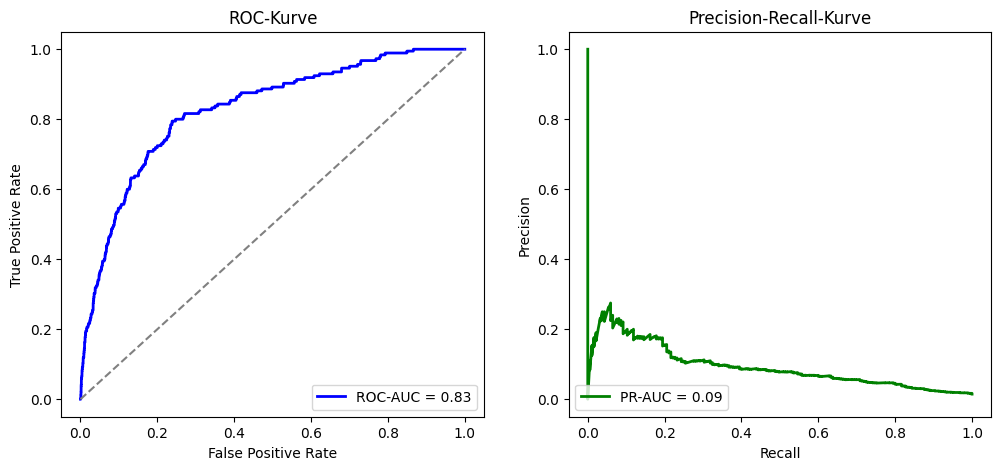

In [327]:
# Berechnung der ROC-Kurve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)


# Berechnung der Precision-Recall-Kurve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
# AUC unter der PR-Kurve berechnen
pr_auc_manual = auc(recall, precision)

# Erstellen der Plots
plt.figure(figsize=(12, 5))

# ROC-Kurve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC-AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonale als Zufallslinie
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Kurve')
plt.legend(loc='lower right')

# Precision-Recall-Kurve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', lw=2, label=f'PR-AUC = {pr_auc_manual:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall-Kurve')
plt.legend(loc='lower left')

# Plots anzeigen
plt.show()


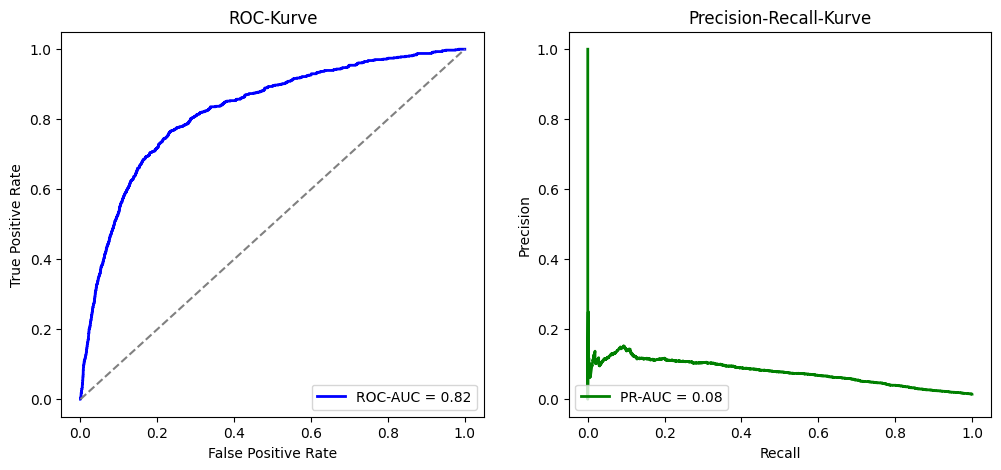

In [328]:
# Vorhersagen berechnen

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
roc_auc_train = auc(fpr_train, tpr_train)


# Berechnung der ROC-Kurve
fpr, tpr, _ = roc_curve(y_train, y_train_pred_proba)
roc_auc = auc(fpr, tpr)



# Berechnung der Precision-Recall-Kurve
precision, recall, _ = precision_recall_curve(y_train, y_train_pred_proba)
# AUC unter der PR-Kurve berechnen
pr_auc_manual = auc(recall, precision)

# Erstellen der Plots
plt.figure(figsize=(12, 5))

# ROC-Kurve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC-AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonale als Zufallslinie
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Kurve')
plt.legend(loc='lower right')

# Precision-Recall-Kurve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', lw=2, label=f'PR-AUC = {pr_auc_manual:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall-Kurve')
plt.legend(loc='lower left')

# Plots anzeigen
plt.show()

In [329]:
# Testdaten-Metriken
y_test_pred = log_reg.predict(X_test_encoded)
y_test_pred_proba = log_reg.predict_proba(X_test_encoded)[:, 1]

accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred_proba)

# Trainingsdaten-Metriken
y_train_pred = log_reg.predict(X_train_encoded)
y_train_pred_proba = log_reg.predict_proba(X_train_encoded)[:, 1]

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)
roc_auc_train = roc_auc_score(y_train, y_train_pred_proba)

# Ergebnisvergleich
evaluation_df = pd.DataFrame({
    "Metrik": ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"],
    "Trainingswerte": [accuracy_train, precision_train, recall_train, f1_train, roc_auc_train],
    "Testwerte": [accuracy_test, precision_test, recall_test, f1_test, roc_auc_test],
    "Differenz (Train-Test)": [
        accuracy_train - accuracy_test,
        precision_train - precision_test,
        recall_train - recall_test,
        f1_train - f1_test,
        roc_auc_train - roc_auc_test
    ]
})

evaluation_df

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Metrik,Trainingswerte,Testwerte,Differenz (Train-Test)
0,Accuracy,0.985334,0.985394,-0.000060
1,Precision,0.000000,0.000000,0.000000
2,Recall,0.000000,0.000000,0.000000
3,F1-Score,0.000000,0.000000,0.000000
4,ROC-AUC,0.824720,0.827806,-0.003086


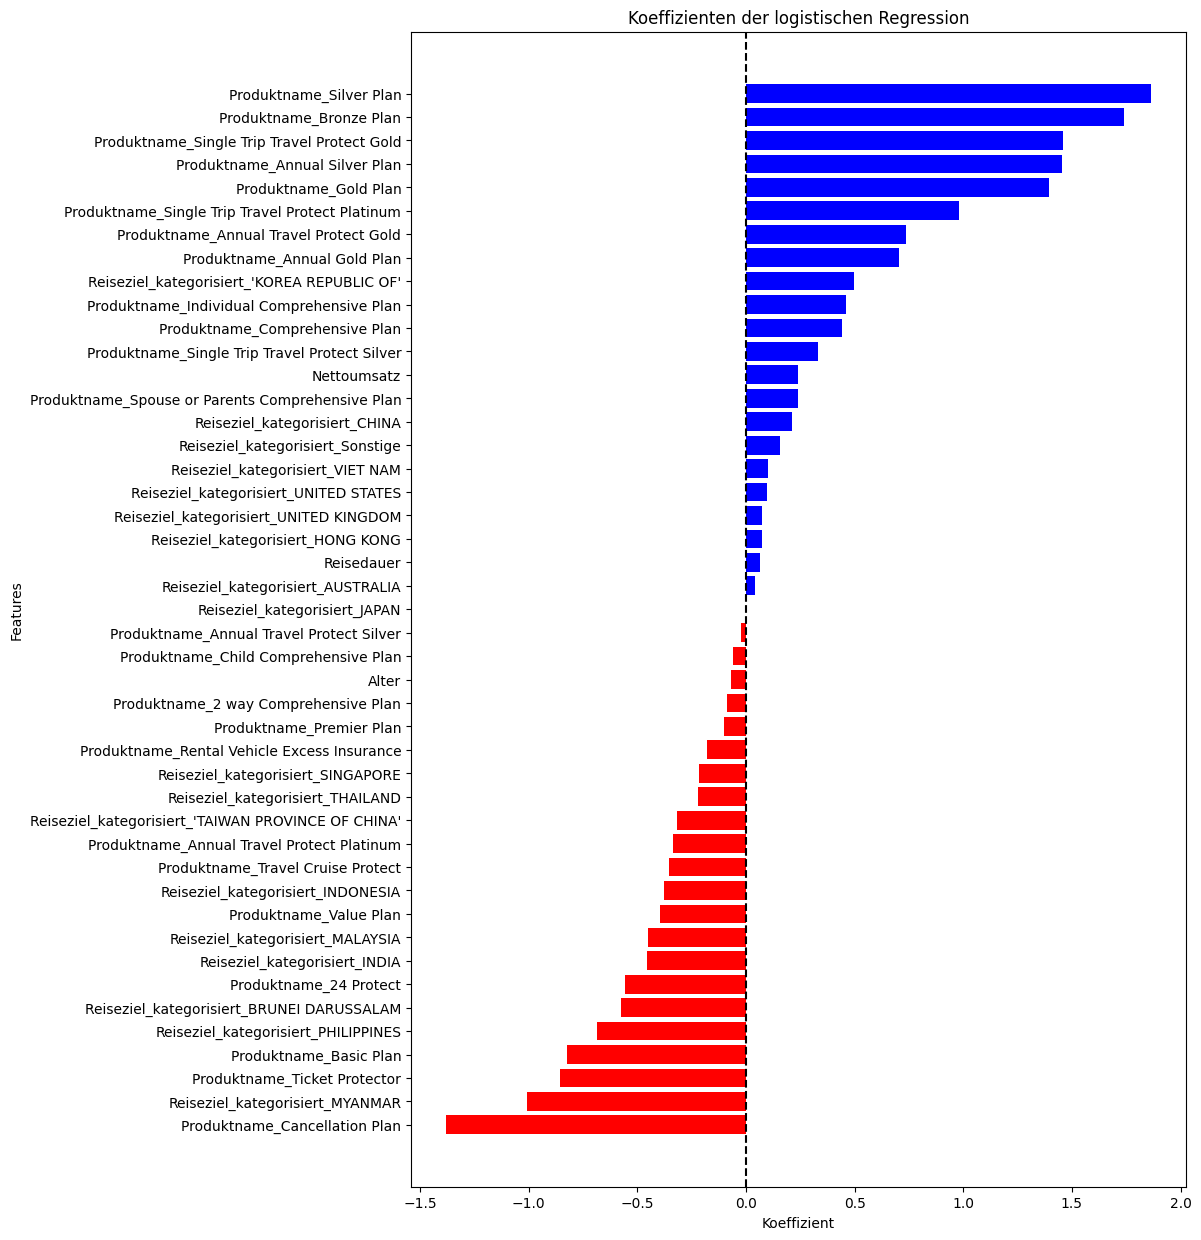

In [330]:
# Koeffizienten abrufen
coefficients = log_reg.coef_[0]  # Da es ein binäres Modell ist, nehmen wir die erste Spalte

features = X_train_encoded.columns

# Erstelle ein DataFrame mit den Koeffizienten
coef_df = pd.DataFrame({'Feature': features, 'Koeffizient': coefficients})

# Nach Größe sortieren
coef_df = coef_df.sort_values(by='Koeffizient', ascending=False)

# Plot der Koeffizienten
plt.figure(figsize=(10, 15))
plt.barh(coef_df['Feature'], coef_df['Koeffizient'], color=np.where(coef_df['Koeffizient'] > 0, 'blue', 'red'))
plt.xlabel("Koeffizient")
plt.ylabel("Features")
plt.title("Koeffizienten der logistischen Regression")
plt.axvline(x=0, color='black', linestyle='--')  # Linie für 0-Koeffizient
plt.gca().invert_yaxis()  # Größte Werte oben
plt.show()

In [331]:
# Log-Odds sind direkt die Koeffizienten
coef_df['Odds Ratio'] = np.exp(coef_df['Koeffizient'])

coef_df

,Feature,Koeffizient,Odds Ratio
19,Produktname_Silver Plan,1.863214,6.444418
11,Produktname_Bronze Plan,1.739230,5.692956
20,Produktname_Single Trip Travel Protect Gold,1.459169,4.302381
6,Produktname_Annual Silver Plan,1.454021,4.280289
15,Produktname_Gold Plan,1.392988,4.026865
21,Produktname_Single Trip Travel Protect Platinum,0.982440,2.670966
7,Produktname_Annual Travel Protect Gold,0.736264,2.088119
5,Produktname_Annual Gold Plan,0.702668,2.019134
27,Reiseziel_kategorisiert_'KOREA REPUBLIC OF',0.497074,1.643904
16,Produktname_Individual Comprehensive Plan,0.459625,1.583480


In [332]:
# Anzahl der vorhergesagten Klassen ausgeben
unique, counts = np.unique(y_pred, return_counts=True)
print(f"Vorhersageverteilung: {dict(zip(unique, counts))}")


Vorhersageverteilung: {0: 12666}


# Model: LightGBM

- Kann möglicherweise besser mit unausgeglichenen Datensätzen umgehen
- Kann möglicherweise Vorhersagequalität verbessern
- Es wurde ein LightGBM-Modell trainiert und evaluiert


## Datenvorbereitung für LigthGBM

- Nur relevante Features behalten (Für eine bessere Interpretierbarkeit der Feature Relevanz)
- Umwandlung kategorialer Features in Datentyp Category


In [333]:
# Drop irrelevante Features
# Liste der zu entfernenden Features
features_to_drop = [ "Vertriebskanal", "Agenturtyp", "Agenturname", "Geschlecht", "Kommission"]

# Entfernen der Features aus X_train und X_test

X_train_gbm = X_train.drop(columns=features_to_drop)
X_test_gbm = X_test.drop(columns=features_to_drop)
y_train_gbm = y_train.drop(columns=features_to_drop)
y_test_gbm = y_test.drop(columns=features_to_drop)



In [334]:
# Liste der kategorischen Features
categorical_features = ["Produktname", "Reiseziel"]



# Umwandlung in den Datentyp 'category'
for col in categorical_features:
    X_train_gbm[col] = X_train_gbm[col].astype('category')
    X_test_gbm[col] = X_test_gbm[col].astype('category')


In [335]:
# Bestimme die Indizes der kategorischen Spalten
categorical_feature_indices = [X_train_gbm.columns.get_loc(col) for col in categorical_features]

In [336]:
categorical_feature_indices

[0, 2]

## Modelltraining

Hinzufügen der Regularisierung für mehr Stabilität bei Overfitting
importance_type="gain" statt split, da gain misst, wie viel das Featrue zur Reduzierung des Fehlers beiträgt und nicht wie oft ein Feature als Split-Kriterium verwendet wurde (Features mit vielen kategorien können bei Split bevorzugt werden z.B. Alter)


In [337]:
# LightGBM trainieren
lgbm_model = LGBMClassifier(n_estimators=100, learning_rate=0.05, max_depth=3, reg_alpha=5, reg_lambda=5, min_split_gain=3, importance_type="gain", random_state=42)
lgbm_model.fit(X_train_gbm, y_train_gbm, categorical_feature=categorical_feature_indices)

# Feature Importances ausgeben
feature_importance = pd.DataFrame({'Feature': X_train_gbm.columns, 'Importance': lgbm_model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Top 20 Features anzeigen
print(feature_importance.head(20))

[LightGBM] [Info] Number of positive: 742, number of negative: 49918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 723
[LightGBM] [Info] Number of data points in the train set: 50660, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.014647 -> initscore=-4.208788
[LightGBM] [Info] Start training from score -4.208788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

## Vorhersage und Evaluierung

Erklärung der Metriken: Siehe Evaluierung Logistische Regression


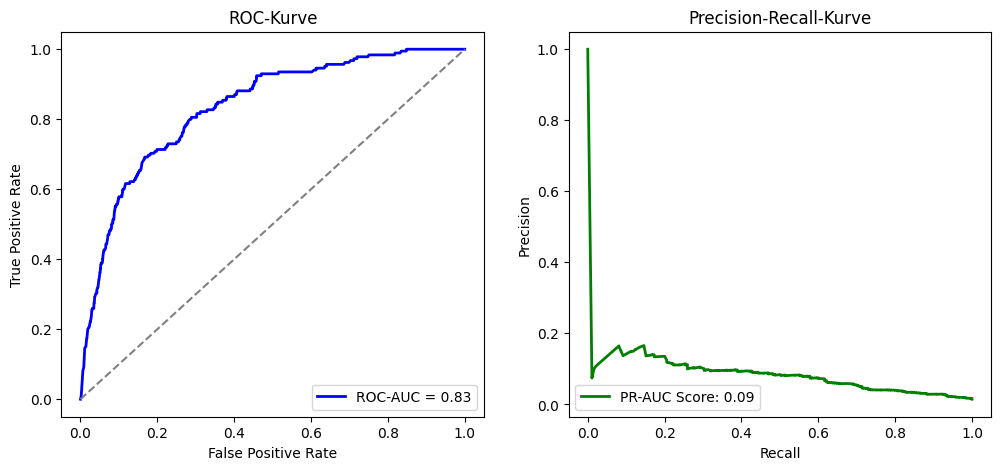

In [338]:
# Vorhersagen berechnen
y_pred_proba_lgbm = lgbm_model.predict_proba(X_test_gbm)[:, 1]

# Berechnung der ROC-Kurve
fpr, tpr, _ = roc_curve(y_test_gbm, y_pred_proba_lgbm)
roc_auc = auc(fpr, tpr)

# Berechnung der Precision-Recall-Kurve
precision, recall, _ = precision_recall_curve(y_test_gbm, y_pred_proba_lgbm)

# AUC unter der PR-Kurve berechnen
pr_auc_manual = auc(recall, precision)

# Erstellen der Plots
plt.figure(figsize=(12, 5))

# ROC-Kurve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC-AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonale als Zufallslinie
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Kurve')
plt.legend(loc='lower right')

# Precision-Recall-Kurve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', lw=2, label=f"PR-AUC Score: {pr_auc_manual:.2f}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall-Kurve')
plt.legend(loc='lower left')

# Plots anzeigen
plt.show()

PR-AUC (manuell berechnet): 0.0858


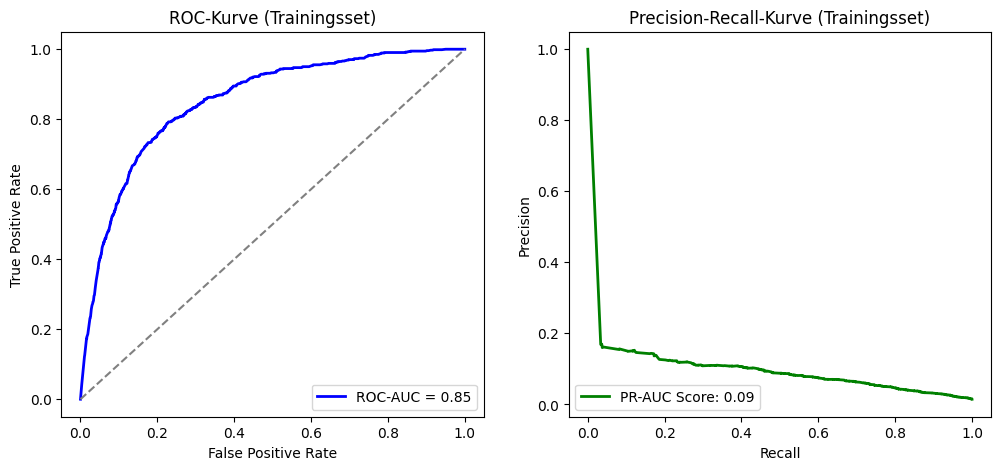

In [339]:
# Berechnung der ROC-Kurve für das Trainingsset

# Vorhersagen berechnen
y_train_pred_proba = lgbm_model.predict_proba(X_train_gbm)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train_gbm, y_train_pred_proba)
roc_auc_train = auc(fpr_train, tpr_train)

# Berechnung der Precision-Recall-Kurve für das Trainingsset
precision_train, recall_train, _ = precision_recall_curve(y_train_gbm, y_train_pred_proba)

# AUC unter der PR-Kurve berechnen
pr_auc_manual = auc(recall, precision)

print(f"PR-AUC (manuell berechnet): {pr_auc_manual:.4f}")

# Erstellen der Plots
plt.figure(figsize=(12, 5))

# ROC-Kurve für das Trainingsset
plt.subplot(1, 2, 1)
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'ROC-AUC = {roc_auc_train:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonale als Zufallslinie
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Kurve (Trainingsset)')
plt.legend(loc='lower right')

# Precision-Recall-Kurve für das Trainingsset
plt.subplot(1, 2, 2)
plt.plot(recall_train, precision_train, color='green', lw=2, label=f"PR-AUC Score: {pr_auc_manual:.2f}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall-Kurve (Trainingsset)')
plt.legend(loc='lower left')

# Plots anzeigen
plt.show()


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


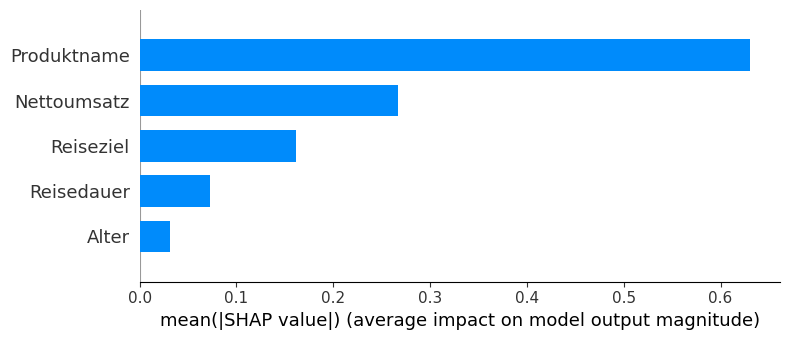

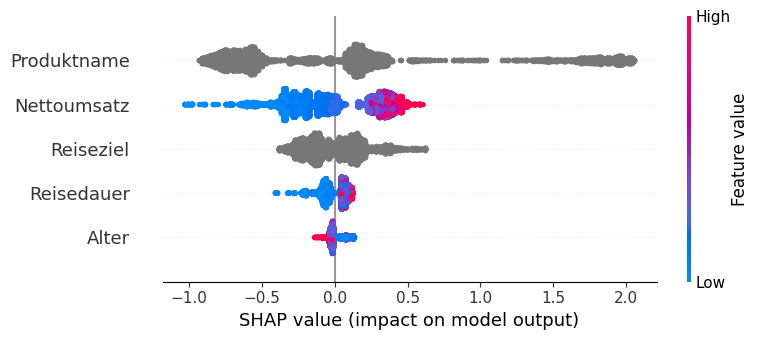

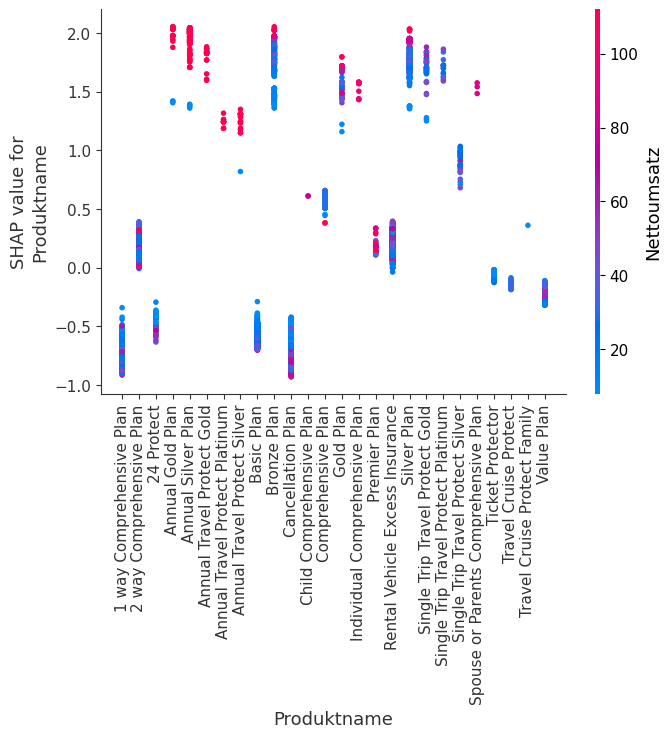

In [340]:
# SHAP-Explainer für LightGBM mit TreeExplainer (besser für Entscheidungsbäume)
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X_test_gbm)

# SHAP-Barplot für Feature Importance
shap.summary_plot(shap_values, X_test_gbm, plot_type="bar")

# SHAP-Beeswarm-Plot für detaillierte Feature-Analyse
shap.summary_plot(shap_values, X_test_gbm)

# SHAP-Werte für einzelne Vorhersagen (Force Plot)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_gbm.iloc[0,:])

# SHAP-Dependence Plot für ein bestimmtes Feature
shap.dependence_plot("Produktname", shap_values, X_test_gbm)

plt.show()


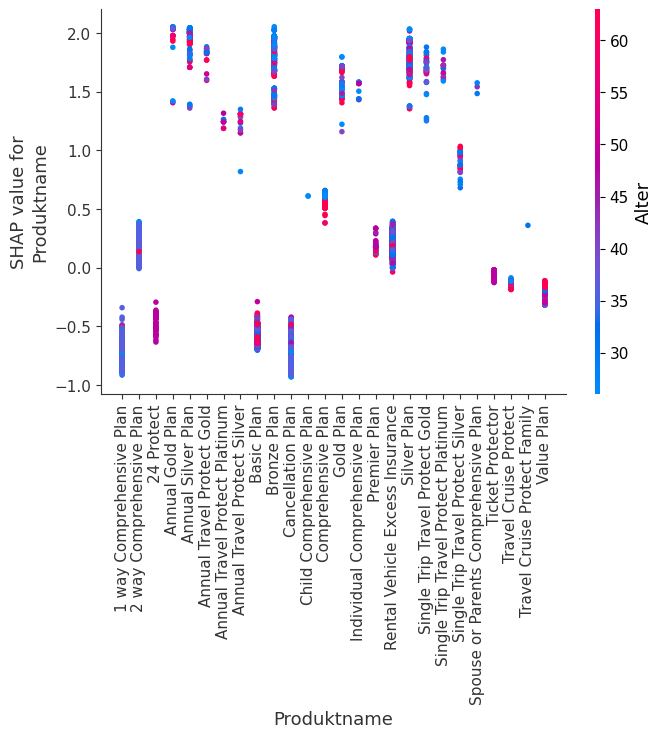

In [341]:
# SHAP-Dependence Plot für "Produktname" mit farblicher Kodierung nach "Reisedauer"
shap.dependence_plot("Produktname", shap_values, X_test_gbm, interaction_index="Alter")

# Anzeige des Plots
plt.show()


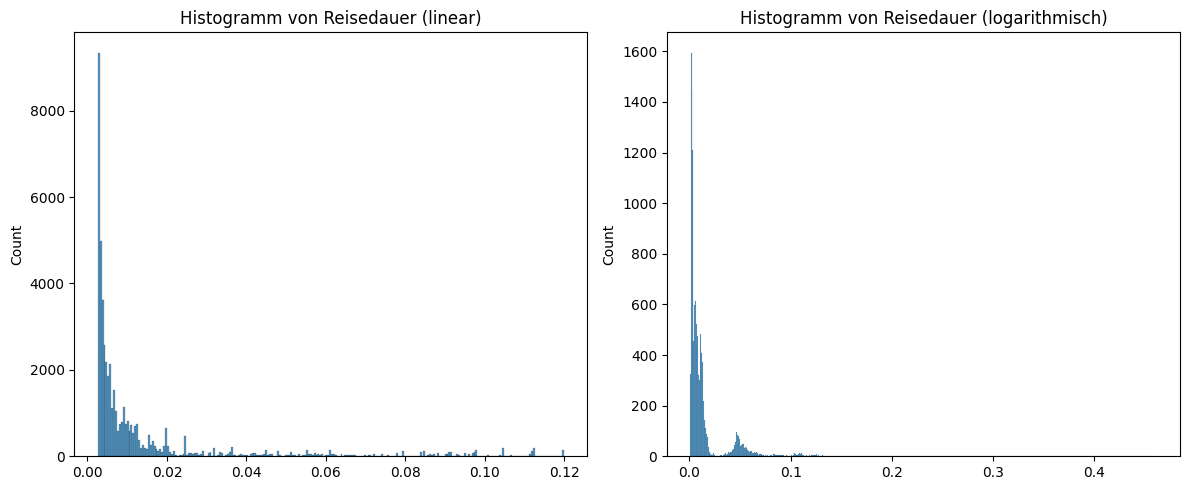

In [342]:
# Erstelle die Subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 Zeile, 2 Spalten

# Lineares Histogramm (links)
sns.histplot(data=y_train_pred_proba, ax=axes[0])
axes[0].set_title("Histogramm von Reisedauer (linear)")

# Logarithmisches Histogramm (rechts)
sns.histplot(data=y_test_pred_proba, ax=axes[1])
axes[1].set_title("Histogramm von Reisedauer (logarithmisch)")

# Layout-Anpassung
plt.tight_layout()
plt.show()

# Einbindung Webservice

In [343]:
lgbm_model.feature_name_

['Produktname', 'Reisedauer', 'Reiseziel', 'Nettoumsatz', 'Alter']

In [344]:
# Modell in eine Datei speichern
#with open('lgbm_model.pkl', "wb") as file:
#    pickle.dump(lgbm_model, file)

In [345]:
#!pip freeze > /content/requirements.txt


In [346]:
#pip show scikit-learn